<a href="https://colab.research.google.com/github/hannahportus/DGU-MLDL/blob/main/CNN_LSTM_T1_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import to_categorical

# 데이터 불러오기
data = pd.read_csv('/content/drive/MyDrive/finaldata.csv')
df = pd.DataFrame(data)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843 entries, 0 to 842
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 843 non-null    object 
 1   BOD                  843 non-null    float64
 2   COD                  843 non-null    float64
 3   SS                   843 non-null    float64
 4   TN                   843 non-null    float64
 5   TP                   843 non-null    float64
 6   EcoliNum             843 non-null    float64
 7   PM10                 843 non-null    float64
 8   PM25                 843 non-null    float64
 9   O3                   843 non-null    float64
 10  NO2                  843 non-null    float64
 11  CO                   843 non-null    float64
 12  SO2                  843 non-null    float64
 13  AverTemp             843 non-null    float64
 14  DailyPrecipitation   843 non-null    float64
 15  AverWinSpeed         843 non-null    flo

In [3]:
# Convert date to datetime object
df['Date'] = pd.to_datetime(df['Date'])

df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Year'] = df['Date'].dt.year

df['PercentChange'] = df['PercentChange'].astype(str)
df['PercentChange'] = df['PercentChange'].str.rstrip('%')
df['PercentChange'] = df['PercentChange'].astype(float)

# x1 = datetime , x2 = env and covid data
x1 = df.iloc[:,23:26]
x2_initial = df.iloc[:,1:22]
x2_column_names = x2_initial.columns

In [4]:
# category encoder - ONE HOT ENCODER
encoder = OneHotEncoder()
df_level = encoder.fit_transform(df[['Level']])
df_level_encoded = pd.DataFrame(df_level.toarray(), columns=encoder.get_feature_names_out(['Level']))

df = pd.concat([df,df_level_encoded], axis=1)

duplicated_columns = df.columns[df.columns.duplicated()]
if duplicated_columns.any():
   # Drop duplicate columns
    df.drop(duplicated_columns, axis=1, inplace=True)

df.info()

# category encoder - LABEL ENCODER
#encoder = LabelEncoder()
#encoder.fit(y_initial)
#encoded_y = encoder.transform(y_initial)

#y = to_categorical(encoded_y)

# x normalization - MIN-MAX SCALER
scaler = MinMaxScaler()
x2_scaled = scaler.fit_transform(x2_initial)
x2 = pd.DataFrame(x2_scaled)
x2 = pd.DataFrame(x2_scaled, columns=x2_column_names)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843 entries, 0 to 842
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        843 non-null    datetime64[ns]
 1   BOD                         843 non-null    float64       
 2   COD                         843 non-null    float64       
 3   SS                          843 non-null    float64       
 4   TN                          843 non-null    float64       
 5   TP                          843 non-null    float64       
 6   EcoliNum                    843 non-null    float64       
 7   PM10                        843 non-null    float64       
 8   PM25                        843 non-null    float64       
 9   O3                          843 non-null    float64       
 10  NO2                         843 non-null    float64       
 11  CO                          843 non-null    float64       

In [5]:
x = pd.concat([x1, x2], axis=1)
y = df.iloc[:,26:33]

In [10]:
# Data Sequencing - parameter: time_series
time_steps = 7
def create_sequences(x, y, time_steps):
    x_seq, y_seq = [], []
    for i in range(len(x) - time_steps):
        x_seq.append(x[i:i+time_steps])
        y_seq.append(y.iloc[i+time_steps])
    return np.array(x_seq), np.array(y_seq)

x_seq, y_seq = create_sequences(x, y, time_steps)

In [11]:
# data splitting to train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_seq, y_seq, test_size=0.2, shuffle=False, random_state=0)

# reshape input data for compatibility with 1D CNN
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1).astype('float32')

y_train = y_train[:len(x_train)]
y_test = y_test[:len(x_test)]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(668, 7, 24, 1)
(168, 7, 24, 1)
(668, 7)
(168, 7)


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, BatchNormalization, Activation, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.losses import CategoricalCrossentropy

# Define model parameters
verbose = 0
epochs = 500
batch_size = 60
n_dim1, n_dim2 = x_train.shape[1], x_train.shape[2]
num_features = n_dim2  # Number of input data features

num_hidden_units1 = 100  # Example number of hidden units for first LSTM layer
num_hidden_units2 = 200  # Example number of hidden units for second LSTM layer
num_hidden_units3 = 100  # Example number of hidden units for third LSTM layer

learning_rate = 0.001
optimizer = Adam(learning_rate)
loss = CategoricalCrossentropy()

# Create CNN-LSTM model
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_dim1, n_dim2)))
#model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(hiddenunits_1))  # Add LSTM layer
#model.add(Dense(hiddenunits_2, activation='relu'))
#model.add(Dense(7, activation='softmax'))
# Compile model
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Print model summary
#model.summary()

def create_cnn_lstm_model(num_features, time_steps, num_hidden_units1, num_hidden_units2, num_hidden_units3):
    model = Sequential([
        Conv1D(filters=100, kernel_size=num_features, padding='same', input_shape=(time_steps, num_features)),
        Dropout(0.3),
        BatchNormalization(),
        Conv1D(filters=500, kernel_size=num_features, padding='same'),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(units=num_hidden_units1, return_sequences=True),
        Dropout(0.2),
        LSTM(units=num_hidden_units2, return_sequences=True),
        Dropout(0.5),
        LSTM(units=num_hidden_units3, return_sequences=True),
        Dropout(0.2),
        Bidirectional(LSTM(units=num_hidden_units3, return_sequences=False)),
        Dense(units=7, activation='softmax')
    ])

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

#model = Sequential()
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, num_features), padding='same'))
#model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
#model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
#model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
#model.add(MaxPooling1D(pool_size=2))
#odel.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
#model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
#model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
#model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
#model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
#model.add(MaxPooling1D(pool_size=2))
#model.add(LSTM(units=100))
#model.add(Dense(units=128, activation='relu'))
#model.add(Dense(units=7, activation='softmax'))
#model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

model = create_cnn_lstm_model(num_features, time_steps, num_hidden_units1, num_hidden_units2, num_hidden_units3)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 7, 100)            57700     
                                                                 
 dropout_10 (Dropout)        (None, 7, 100)            0         
                                                                 
 batch_normalization_4 (Bat  (None, 7, 100)            400       
 chNormalization)                                                
                                                                 
 conv1d_5 (Conv1D)           (None, 7, 500)            1200500   
                                                                 
 dropout_11 (Dropout)        (None, 7, 500)            0         
                                                                 
 batch_normalization_5 (Bat  (None, 7, 500)            2000      
 chNormalization)                                     

In [16]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=verbose)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=verbose)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on test data
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')
recall = recall_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_classes, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Test Loss: 1.6325287818908691
Test Accuracy: 0.255952388048172
6/6 [==============================] - 3s 8ms/step
Precision: 0.3527077497665733
Recall: 0.25595238095238093
F1 Score: 0.20999598136596828


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6/6 [==============================] - 1s 215ms/step


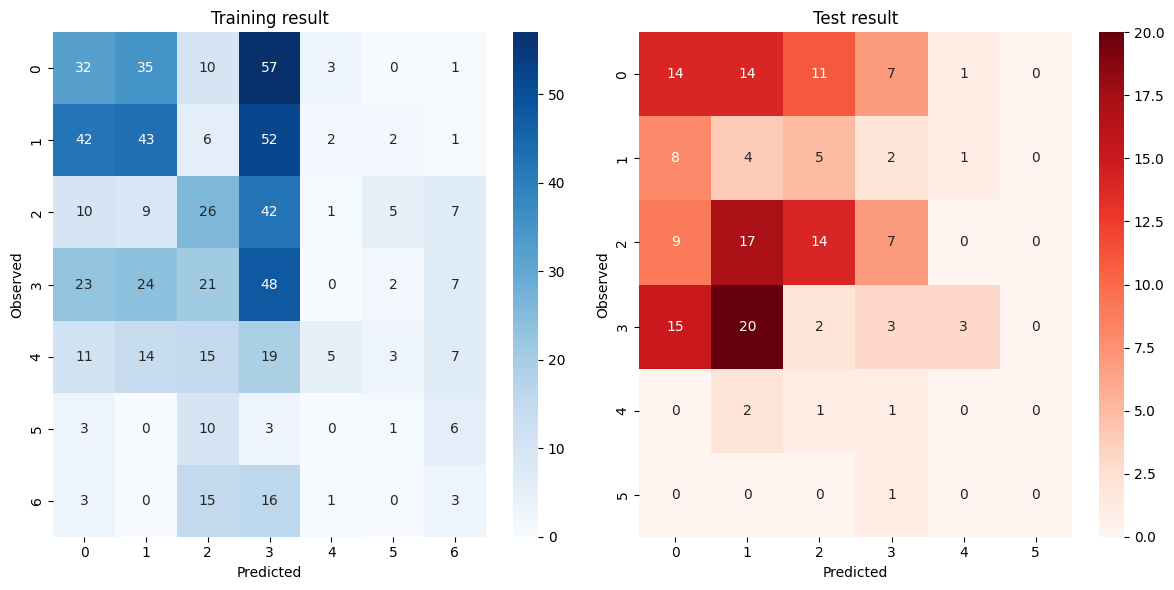

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

pre_train_index = model.predict(x_train).argmax(axis=1)
obs_train_index = np.argmax(y_train, axis=1)
pre_test_index = model.predict(x_test).argmax(axis=1)
obs_test_index = np.argmax(y_test, axis=1)

result_train = confusion_matrix(obs_train_index, pre_train_index)
result_test = confusion_matrix(obs_test_index, pre_test_index)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(result_train, annot=True, fmt='d', cmap='Blues')
plt.title('Training result')
plt.xlabel('Predicted')
plt.ylabel('Observed')

plt.subplot(1, 2, 2)
sns.heatmap(result_test, annot=True, fmt='d', cmap='Reds')
plt.title('Test result')
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.tight_layout()
plt.show()

In [9]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (646, 35, 24, 1)
y_train shape: (646, 7)
x_test shape: (162, 35, 24, 1)
y_test shape: (162, 7)
